In [1]:
import os
import glob
import random

import torch
import torchvision
import numpy as np
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

from IPython.display import Image

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

## Датасет

Ссылка на датасет - https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza

Датасет состоит из изображений еды и изображений пиццы

Всего 2 класса.

Изображения изначально разных размеров, приведем изображения к одному размеру 100 на 100 пикселей

In [3]:
DATA_PATH = r'D:\ProgrammingPython\neural_networks\pizza_not_pizza'
DATA_PATH

'D:\\ProgrammingPython\\neural_networks\\pizza_not_pizza'

In [4]:
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

In [5]:
classes_img_stat = {}
for cls in os.listdir(DATA_PATH):
    cls_path = os.path.join(DATA_PATH, cls)
    classes_img_stat[cls] = []
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        classes_img_stat[cls].append(img.shape[:2])

In [6]:
stastics_arr = []
for key in classes_img_stat:
    buff_arr = np.array(classes_img_stat[key])
    stats ={
        'cls_mean' : buff_arr.mean(axis=0),
        'cls_max'  : buff_arr.max(axis=0),
        'cls_min'  : buff_arr.min(axis=0),
    }
    stastics_arr.append([
        buff_arr.mean(axis=0),
        buff_arr.max(axis=0),
        buff_arr.min(axis=0)
        ])
    print(key)
    print(stats)

not_pizza
{'cls_mean': array([470.66937945, 497.51373347]), 'cls_max': array([512, 512]), 'cls_min': array([287, 288])}
pizza
{'cls_mean': array([468.64598169, 489.72024415]), 'cls_max': array([512, 512]), 'cls_min': array([287, 287])}


In [7]:
arr = np.array(stastics_arr)
print(f"Среднее по высоте: {arr[:, 0, 0].mean()}")

Среднее по высоте: 469.65768056968466


In [8]:
print(f"Среднее по ширине: {arr[:, 0, 1].mean()}")

Среднее по ширине: 493.616988809766


In [9]:
# Выберем один размер для всех изображений
size = [100, 100]
size

[100, 100]

In [10]:
import matplotlib.pyplot as plt

Проверим, сохранятся ли пропорции изображения при изменении размера

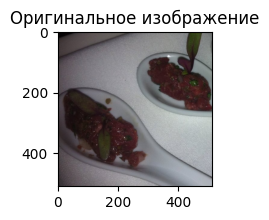

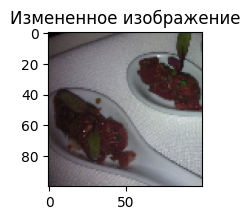

In [11]:
for cls in os.listdir(DATA_PATH):
    cls_path = os.path.join(DATA_PATH, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(2, 2))
        plt.imshow(img)
        plt.title("Оригинальное изображение")
        plt.show()

        stretch_near = cv2.resize(img, size, interpolation = cv2.INTER_LINEAR)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(2, 2))
        plt.imshow(stretch_near)
        plt.title("Измененное изображение")
        plt.show()
        break
    break

Сохраним измененный датасет

In [12]:
AUGMENTED_DATA_PATH = r'D:\ProgrammingPython\neural_networks\pizza_not_pizza_100'
if not os.path.exists(AUGMENTED_DATA_PATH):
    os.makedirs(AUGMENTED_DATA_PATH)

In [13]:
# Изменяем все изображения в датасете, чтобы размер был (200, 200)
for cls in os.listdir(DATA_PATH):
    cls_path = os.path.join(DATA_PATH, cls)
    cls_aug_path = os.path.join(AUGMENTED_DATA_PATH, cls)
    if not os.path.exists(cls_aug_path):
        os.makedirs(cls_aug_path)
    os.chdir(cls_aug_path) 
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        aug_img_path = os.path.join(cls_aug_path, cls)
        img = cv2.imread(img_path)

        stretch_near = cv2.resize(img, size, interpolation = cv2.INTER_LINEAR)
        cv2.imwrite(img_name, stretch_near) 

In [38]:
DATA_PATH = r'D:\ProgrammingPython\neural_networks\pizza_not_pizza_100'
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

class PizzaDataset(Dataset):
    
    def __init__(self, rootdir, transform) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)
            
    def __len__(self):
        return len(self.images_pathes)
    
    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)
        
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [39]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

In [40]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

Оригинальный датасет не разделен на тренировочную и тестовую выборки, поэтому разделим датасет в соотношении 80 на 20

In [41]:
TEST_SIZE = 0.2
BATCH_SIZE = 64
SEED = 0

In [42]:
dataset = PizzaDataset(DATA_PATH, transform)

In [43]:
generator = torch.Generator().manual_seed(SEED)

train_dataset, test_dataset = random_split(dataset, [1-TEST_SIZE, TEST_SIZE], generator=generator)

In [44]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [45]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break


torch.Size([64, 3, 100, 100])
tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0])


## Модель

In [46]:
# выход с последнего слоя
print(f"Кол-во классов: {len(classes.values())}")

Кол-во классов: 2


In [47]:
print(229//2)

114


Напишем полносвязную нейронную сеть классификатор

In [48]:
class PizzaClassificator(nn.Module):
    def __init__(self):
        super(PizzaClassificator, self).__init__()
        self.linear_1 = nn.Linear(30000, 512)
        self.linear_2 = nn.Linear(512, 128)
        self.linear_3 = nn.Linear(128, 32)
        self.linear_4 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)
        x = F.tanh(x)
        x = self.linear_3(x)
        x = F.tanh(x)
        x = self.linear_4(x)
        
        return x

In [49]:
model = PizzaClassificator()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.001,)

In [50]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    acc = 0
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):


            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*BATCH_SIZE
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        print('precision =', acc)

    return acc


In [51]:
accuracy = train(train_loader, model, loss_function, optimizator, 5)

loss = 0.6944723129272461, samples = 64
precision = 0.6641221374045801
loss = 0.6148571968078613, samples = 128
precision = 0.7073791348600509
loss = 0.5185793042182922, samples = 192
precision = 0.7430025445292621
loss = 0.495418518781662, samples = 256
precision = 0.7786259541984732
loss = 0.4922194480895996, samples = 320
precision = 0.7964376590330788


Сохраним модель, указав датасет, кол-во эпох и точность

In [52]:
accuracy = (accuracy*100)
output_str = f"fullyConnected_pizza_100_classificator_5_{accuracy:.2f}"
output_str = output_str.replace(".", "_")
output_str = output_str + '.pt'
print(output_str)

fullyConnected_pizza_100_classificator_5_79_64.pt


In [53]:
torch.save(model, output_str)

## Оценка модели

In [54]:
model.to('cpu')
model(x).size()

torch.Size([64, 2])

In [55]:
model.eval()

PizzaClassificator(
  (linear_1): Linear(in_features=30000, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=128, bias=True)
  (linear_3): Linear(in_features=128, out_features=32, bias=True)
  (linear_4): Linear(in_features=32, out_features=2, bias=True)
)

In [56]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to('cpu')), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


7


Сравним истинные метки и ответы модели на первых десяти метках

In [83]:
print(f'labels  : {labels[:10]}')
print(f'predicts: {predicts[:10]}')

labels  : [1 1 0 0 1 1 0 1 0 0]
predicts: [1 1 0 0 1 1 0 0 0 0]


In [59]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [84]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))
cm.shape


(2, 2)

In [85]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Выведем матрицу ошибок

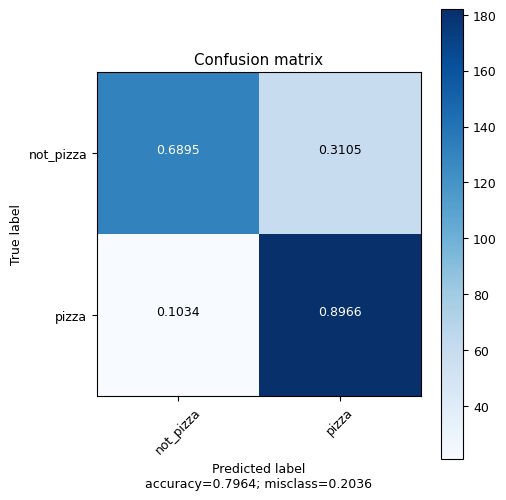

In [86]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 9})
plot_confusion_matrix(cm, tuple(classes.values()))